# Part 1: River

## Member: Yunhao CHEN

`River` is an open-source machine learning library for data streams. It is being developed by  **Télécom ParisTech**, **École Polytechique**, and the **University of Waikato**.

In this lab we will use `River`. Visit the page of the [library](https://riverml.xyz/) and follow the [installation instructions](https://riverml.xyz/latest/getting-started/installation/).

**Notice:** `River` requires `NumPy` and `Cython`
Also, for this lab you will need: `scikit-learn`, `pandas`, and `matplotlib`.

**Important:** River version used: `0.14.0`. The way of using functions may be different if you use another version.

# Classification in Data Streams

The goal of this lab is to build a classifier capable of learning and making predictions in a datastream using the `River` library. In this lab we are comparing three datastream classifiers on Electricity dataset:
- kNN
- Hoeffding Tree
- Batch-Incremental Ensemble Classifier (BIE)

The last of the three classifiers is not implemented yet. This is the task of this lab. You should implement the `learn_one` and `predict_one` methods in the `BatchClassifier` class. 

Tasks:
1. Implement a tumbling window of size 100, creating and maintaining up to a maximum of 100 models. 
2. Build a batch `DecisionTreeClassifier` on each of the batches/windows.

**Note:** The Decision Tree is a batch model that takes as input `np.array`. You can convert dictionaries (default data type in `River`) into `np.array` with the utility method `dict2numpy` available in `river.utils` 

In [1]:
from river import utils

In [2]:
from sklearn.tree import DecisionTreeClassifier

class BatchClassifier:

    def __init__(self, window_size=100, max_models=100):
        self.H = [] # list of models
        # self.h = None 
        self.window_size = window_size # max number of observations stored in the buffer
        self.max_models = max_models # max number of models stored in H
        self.buffer_x = [] # a buffer with the 'window_size' most recent observations.
        self.buffer_y = [] # a buffer store the label
        # TODO

    def learn_one(self, x, y=None):
        # TODO 
        self.buffer_x.append(utils.dict2numpy(x))
        self.buffer_y.append(y)
        if len(self.buffer_x) >= self.window_size:
          h = DecisionTreeClassifier()
          h.fit(self.buffer_x, self.buffer_y)
          self.H.append(h)
          self.buffer_x = []
          self.buffer_y = []
          if len(self.H) > self.max_models:
            self.H.pop(0)
        # if not initialized ...
            # Setup 
        # HINT: You can build a decision tree model on a set of data like this:
              # h = DecisionTreeClassifier()
        #       h.fit(X_batch, y_batch)
        #       self.H.append(h) # <-- and append it to the ensemble

        return self

    def predict_one(self, x):
        # TODO
        # Be mindful of the case when the model is still empty and predictions are requested.
        # The best practice is to return a default value.
        preds = []
        if len(self.H) > 0:
          for f in self.H:
            preds.append(f.predict(utils.dict2numpy(x).reshape(1,-1))[0])
          return max(preds,key=preds.count)
        return 0 

## Evaluation

Here we provide auxiliary functions and setup the evaluation. The `evaluate` method implements the test-then-train evaluation and tracks performance using `accuracy` and `kappa`. For each metric, two values are calculated: **prequential** (or rolling) indicates the performance of the model over a sliding window and **test-then-train** represents the performance of the model over *all* seen data from the stream. The method returns a dataframe with the results for the test calculated every `n_wait` samples (metrics are updated on every new sample). These results are used to plot performance later in the notebook.

**Note:** You do not need to modify the code in the following cell.

In [7]:
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.stream import iter_pandas
from river import metrics
import time

import pandas as pd

dataset = "elec"

def print_progress(sample_id, acc, kappa):
    print(f'Samples processed: {sample_id}')
    print(acc)
    print(kappa)

def evaluate(stream, model, n_wait=1000, verbose=False):
    acc = metrics.Accuracy()
    acc_rolling = utils.Rolling(metrics.Accuracy(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = utils.Rolling(metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    start = time.process_time()
    for i, (x, y) in enumerate(stream):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        acc_rolling.update(y_true=y, y_pred=y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        kappa_rolling.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, acc, kappa)
            raw_results.append([model_name, i, acc.get(), acc_rolling.get(), kappa.get(), kappa_rolling.get()])
        # Learn (train)
        model.learn_one(x, y)
    print_progress(i, acc, kappa)
    CPU_time = time.process_time() - start
    print(f"CPU time : {round(CPU_time, 2)} seconds")
    return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'acc_roll', 'kappa', 'kappa_roll'])

# Load the data, will be transformed into a stream later
df = pd.read_csv("./data/"+dataset+".csv")
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]

# Initialize models
knn = KNNClassifier(n_neighbors=10, window_size=100)
ht = HoeffdingTreeClassifier()
bie = BatchClassifier(window_size=100, max_models=100)

#### Extra points

Modify the evaluation to report training and testing time. Modify the plotting code accordingly to report processing time as well.

### Run experiments

Note that we convert the stream (`iter_pandas`) on each call to `evaluate`, this ensures that we are passing the stream properly initialized.

In [8]:
knn_results = evaluate(stream=iter_pandas(X=X, y=Y),
                       model=knn)

Samples processed: 45310
Accuracy: 80.32%
CohenKappa: 59.58%
CPU time : 24.88 seconds


In [9]:
ht_results = evaluate(stream=iter_pandas(X=X, y=Y),
                      model=ht)

Samples processed: 45310
Accuracy: 77.85%
CohenKappa: 54.00%
CPU time : 6.34 seconds


In [10]:
bie_results = evaluate(stream=iter_pandas(X=X, y=Y),
                      model=bie)

Samples processed: 45310
Accuracy: 75.21%
CohenKappa: 48.58%
CPU time : 263.2 seconds


## Generate plots

The code below uses the raw results from the `evaluate` method to generate the plots for `accuracy` and `kappa` and generates a `pdf` file. 

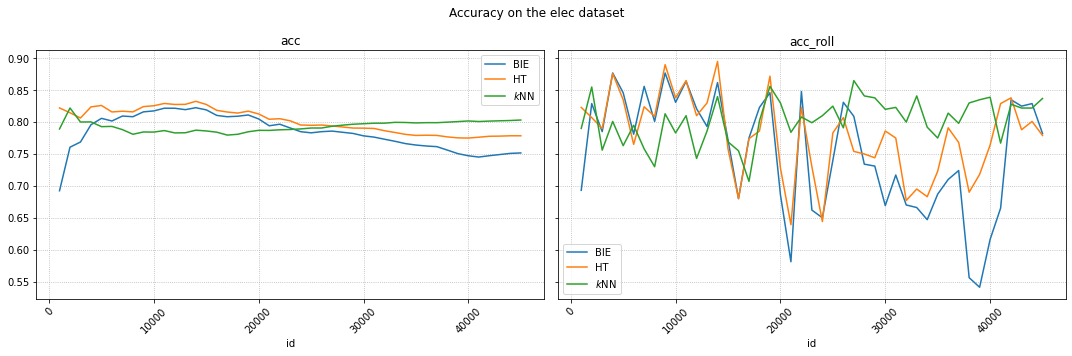

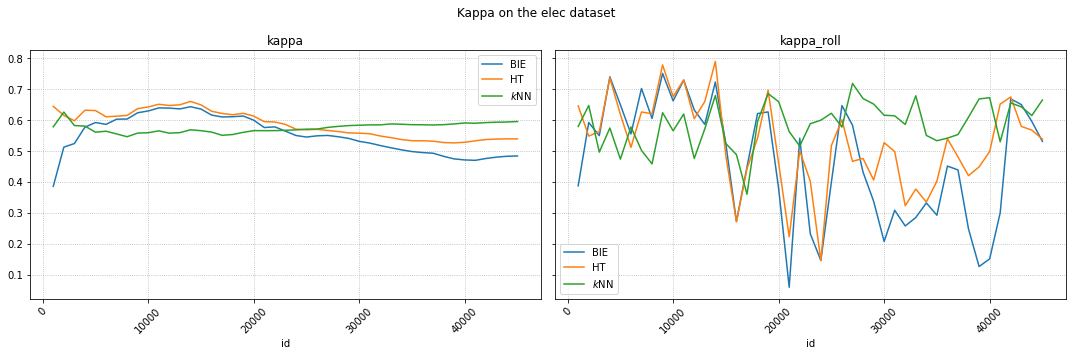

In [11]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

dataset = "elec"

df = pd.concat([knn_results, ht_results, bie_results])
df.set_index('id', inplace=True)
grouped = df.groupby('model')

with PdfPages(f'results_{dataset}.pdf') as pdf:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['acc', 'acc_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(["BIE", "HT", r"$k$NN"], loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Accuracy on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['kappa', 'kappa_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(["BIE", "HT", r"$k$NN"], loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Kappa on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page


**Comments:** For these three classifiers, the average accuracy and kappa tend to be stable. However, the rolling accuracy and rolling kappa on a window of size 1000 are not really stable. 

If we pay attention to the execution time, the BIE method is much slower than other 2 built-in methods.

We notice that the rolling metric tendency of these three classifiers are similar. From this point, we may deduce that the fluctuation of rolling metric results from the unstable quality of data streaming. It is a challenge for all algorithms concerning about data streaming.

## Deliverables

You should submit:
1. The Jupyter Notebook 
2. `html` version of notebook (go to: `File/Download as/HTML`), with visible outputs of your code

in a compressed file (`.zip`, `.rar`, `tar.gz`...), and compressed file should be named: `firstname_lastname_lab2.zip`

In [14]:
!jupyter nbconvert --to html River_discover.ipynb

[NbConvertApp] Converting notebook River_discover.ipynb to html
[NbConvertApp] Writing 814895 bytes to River_discover.html
